In [2]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

- create a dataframe where each user of the test group has the average difference,
number of pageviews and number of commits
- do not take project1 into account for calculations of the average difference and the
number of commits
- take the number of commits from the checker table
- the figsize is still the same, you can choose whatever fontsize you like as well as the
color palette
- the size of the dots should be 200
- the width of the lines of the diagonal graphs (kde) should be 3
- at the end of your Jupyter Notebook, create a markdown cell and insert the questions:

    - “Can we say that if a user has a low number of pageviews then they likely
    have a low number of commits?” The answer: yes or no.
    - “Can we say that if a user has a low number of pageviews then they likely have
    a small average difference between the first commit and the lab deadline?” The
    answer: yes or no.
    - “Can we say that there are many users with a low number of commits and a
    few with a high number of commits”? The answer: yes or no.
    - “Can we say that there are many users with a small average difference and a
    few with a large average difference”? The answer: yes or no.

In [3]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [4]:
schema_query = "PRAGMA table_info(datamart);"
schema = pd.io.sql.read_sql(schema_query, conn)
print(schema)

   cid             name  type  notnull dflt_value  pk
0    0              uid  TEXT        0       None   0
1    1          labname  TEXT        0       None   0
2    2  first_commit_ts   NUM        0       None   0
3    3    first_view_ts              0       None   0


In [7]:
num_commits = pd.io.sql.read_sql(
    """
    SELECT
        uid,
        COUNT(*) num_commits
    FROM checker 
    WHERE uid LIKE 'user_%' AND labname <> 'project1'
    GROUP BY 1
    """, 
    conn, index_col='uid')
num_commits.head(5)

,num_commits
uid,
user_0,3
user_1,62
user_10,20
user_11,7
user_12,86


In [8]:
query = '''
SELECT uid, COUNT(*) AS pageviews
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY 1
'''
pageviews = pd.io.sql.read_sql(query, conn, index_col='uid')
pageviews.head(5)

,pageviews
uid,
user_1,28
user_10,89
user_14,143
user_17,47
user_18,3


In [14]:
corr_query = """
SELECT uid, 
    AVG(diff) AS avg_diff 
FROM (SELECT test.uid, 
        CAST((julianday(test.first_commit_ts)- julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 AS INTEGER) AS diff
    FROM test
        LEFT JOIN deadlines ON test.labname = deadlines.labs
    WHERE test.labname != 'project1') t
    JOIN pageviews USING(uid)
GROUP BY uid;
"""
avg_diff = pd.io.sql.read_sql(corr_query, conn, index_col='uid')
avg_diff.head(3)

,avg_diff
uid,
user_1,-64.4
user_10,-74.8
user_14,-159.0


In [22]:
pageviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, user_1 to user_9
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   pageviews  13 non-null     int64
dtypes: int64(1)
memory usage: 764.0+ bytes


In [25]:
df_merged = pd.concat([avg_diff, pageviews, num_commits], axis=1, join='inner')
df_merged

,avg_diff,pageviews,num_commits
uid,,,
user_1,-64.400000,28,62
user_10,-74.800000,89,20
user_14,-159.000000,143,61
user_17,-61.600000,47,51
user_18,-5.666667,3,5
user_19,-98.750000,16,118
user_21,-95.500000,10,65
user_25,-92.600000,179,79
user_28,-86.400000,149,60


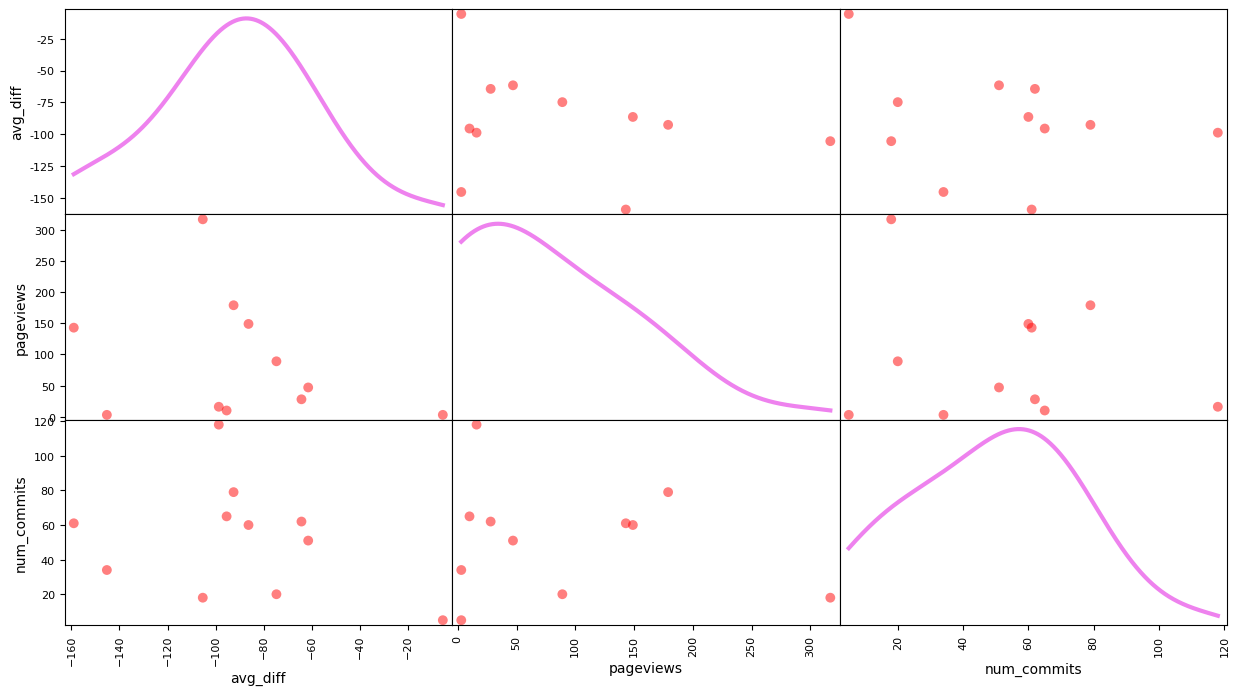

In [33]:
ax = scatter_matrix(df_merged,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='violet', linewidth=3),
                    s=200,
                    color='red')

In [34]:
conn.close()

- “Can we say that if a user has a low number of pageviews then they likely
have a low number of commits?” 
    - The answer: no.
- “Can we say that if a user has a low number of pageviews then they likely have
a small average difference between the first commit and the lab deadline?” 
    - The answer: no.
- “Can we say that there are many users with a low number of commits and a
few with a high number of commits”? 
    - The answer: yes.
- “Can we say that there are many users with a small average difference and a
few with a large average difference”? 
    - The answer: no.